# Train the sequence model on raw data

## Embed arts and shadings

#### 1. train the embed model with custom dataset

In [1]:
# we requires latest version of pytorch and torchvision
!pip install -r requirements.txt

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


`ImageDataset` is a customized dataset that load images from multiple folders, and transform them.

Here we examine whether the transformed images looks the same with the original ones.

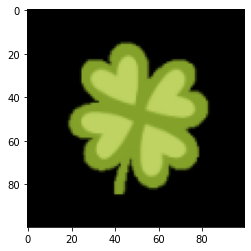

In [2]:
# sanity check: how the transformed image looks like
from dataset.rawdata import ImageDataset
import matplotlib.pyplot as plt
from torchvision import transforms
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((100, 100))
    ])
data = ImageDataset(transform, '../data/asset/art', '../data/asset/shading')
plt.imshow(data[0].permute((1, 2, 0)))
plt.show()

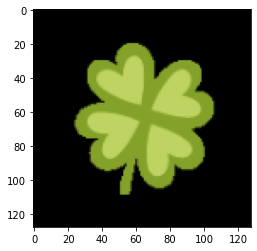

In [3]:
# compare with how the original picture looks like
from skimage import io
img0 = io.imread(data.img_paths[0])
plt.imshow(img0[:,:,:3]) # remove alpha channel
plt.show()

Run this script to train an embedding model with images from arts and shadings. 

The trained model will be saved to `output/convcoder_raw.pt`.

In [4]:
#!python embedding/embedding_main.py --data-set raw --lr 0.001 --epochs 400

#### 2. load embedder

In [5]:
import torch
from embedding.models.embed_model import ConvEncoderDecoder

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
convcoder = ConvEncoderDecoder().to(device)
convcoder.load_state_dict(torch.load('output/convcoder_raw.pt', map_location=device))

<All keys matched successfully>

#### 3. pre-load embeddings of foreground images and background images

In [7]:
import glob
from skimage import io
from torchvision import transforms 

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((100, 100))
    ])

def encode(image, convcoder):
    image = transform(image)
    image = image.unsqueeze(dim=0).to(device)
    with torch.no_grad():
        emb = convcoder.encoder(image)
        emb = torch.flatten(emb, start_dim=1, end_dim=-1)
        emb = convcoder.embedder(emb)
        emb = emb.cpu()
    return emb

def get_embeddings(image_dir, encoder):
    '''
    Parameters:
    image_dir: str
    encoder: nn.Module

    Returns:
    a dict of {image_number:embedding} pair
    '''
    
    image_paths = glob.glob(image_dir + '/*.png')
    assert len(image_paths) != 0, 'No png image found'
    # TODO: use scikitimage to read image to keep rgb order
    images = {int(path.split('/')[-1].split('.')[0]): io.imread(path) for path in image_paths}
    encoded_images = {image_number: encode(image[:,:,:3], encoder)[0] for image_number, image in images.items()}
    return encoded_images

`fg_embs` and `bg_embs` is a dictionary of fore- and background embeddings, indexed by the number of fore-/background.

In [8]:
fg_embs = get_embeddings('../data/asset/art', convcoder)
bg_embs = get_embeddings('../data/asset/shading', convcoder)

## Define Preprocess Methods

In [9]:
# these magic numbers come from inspection of raw data
SCALE_FACTOR_X = 402
SCALE_FACTOR_Y = 600

In [10]:
import json
from collections import defaultdict
from PIL import ImageColor

def hex2rgb(hex_str):
    return ImageColor.getcolor(hex_str, "RGB")

def truncate(x, lower, upper):
    if x < lower:
        return lower
    if x > upper:
        return upper
    return x

def normalize_relative_xy(x, y):
    '''
    normalize x, y from [-402, 402] and [-600, 600] to [-1, 1]
    '''
    x = truncate(x/SCALE_FACTOR_X, -1, 1)
    y = truncate(y/SCALE_FACTOR_Y, -1, 1)
    return x, y

def rescale_fgs(fgs):
    '''
    Make raw foreground meta data compatible with model
    x, y: convert to relative to last position, scale to [-1, 1]
    rotate: convert from [0, 360] to [0, 1]
    
    Parameters:
    fgs: a list of (number, rank, x, y, scale, rotate, opaque)
    '''
    rescaled_fgs = []
    for i, fg in enumerate(fgs):
        number, rank, x, y, scale, rotate, opaque = fg
        if i == 0:
            x_last, y_last = x, y
        # convert rotate in [0, 360] to [0, 1]
        rescaled_rotate = rotate / 360
        x_rel, y_rel = x - x_last, y - y_last
        # normalize x_rel and y_rel to [-1, 1]
        x_rel, y_rel = normalize_relative_xy(x_rel, y_rel)
        # update last records
        x_last, y_last = x, y
        rescaled_fgs.append((number, rank, x_rel, y_rel, scale, rescaled_rotate, opaque))
    return rescaled_fgs
    
def color_emb(emb, color):
    '''
    Append color embedding to a given embedding
    
    Parameters:
    emb (tensor): embedding of shape (emb_size, )
    color (str or tuple): color in hex or tuple, i.e.'#FFFFFF' or (255, 255, 255)
    '''
    if isinstance(color, str):
        r, g, b = hex2rgb(color)
    else:
        r, g, b = color
    r, g, b = r/255, g/255, b/255
    return torch.cat((emb, torch.tensor([r, g, b])))

def build_raw_data(bg_embs, fg_embs, img_list, batch_size):
    '''
    Generate training data with a meta file and corresponding embeddings.
    Data is first grouped by foreground sequence lengths. Then mini-batches are
    created within each group. Finally all mini-batches are gathered and returned.
    
    Parameters:
    bg_embs: dict 
        background embedding dictionary. key: number; entry: tensor of shape (emb_size, )
    fg_embs: dict
        foreground embedding dictionary. key: number; entry: tensor of shape (emb_size, )
    img_manifest_path: str
    batch_size: int
    
    Returns:
    data_batch: list of (in_seqs, bk_embs, cls_labels) tuples
        in_seqs: torch.Tensor of (seq_len, batch_size, fg_emb_size + 5)
        bk_embs: torch.Tensor of (batch_size, bk_emb_size)
        cls_labels: torch.Tensor of (batch_size)
    '''
    # group image by foreground art sequence length
    img_group = defaultdict(list)
    for img_info in img_list:
        img_group[len(img_info['fg'])].append(img_info)
    
    training_data = []
    # process data according to their different foreground sequence length
    for fg_len, imgs in img_group.items():
        # create mini-batch for data of a certain foreground sequence length
        for i in range(0, len(imgs), batch_size):
            fg_reps_batch = []
            cls_label_batch = []
            bk_emb_batch = []
            for img_info in imgs[i:i+batch_size]:
                # record last x and y for calculating relative position
                x_last = int(img_info['fg'][0][2])
                y_last = int(img_info['fg'][0][3])
                fg_reps = []
                # convert x, y to relative positions; scale rotate to 1/360
                rescaled_fgs = rescale_fgs(img_info['fg'])
                fg_reps = [torch.cat((fg_embs[fg[0]], torch.tensor(fg[-5:]))) for fg in rescaled_fgs]
                fg_reps = torch.stack(fg_reps)
                fg_reps = fg_reps.unsqueeze(dim=1) # (steps, mb_size=1, fg_emb_dim+5), 1 is the batch_size
                # covert class label from [-1, 1] to [0, 2] (0 bad, 1 neutral, 2 good)
                cls_label = int(img_info['flag']) + 1
                cls_label = torch.tensor(cls_label, dtype=torch.long).unsqueeze(dim=0) # (mb_size=1, 1)
                # embed background color into 
                bk_emb = color_emb(bg_embs[img_info['bg']], img_info['bgColor'])
                bk_emb = bk_emb.unsqueeze(dim=0)
                fg_reps_batch.append(fg_reps)
                cls_label_batch.append(cls_label)
                bk_emb_batch.append(bk_emb)
            fg_reps_batch = torch.cat(fg_reps_batch, dim=1)
            cls_label_batch = torch.cat(cls_label_batch, dim=0)
            bk_emb_batch = torch.cat(bk_emb_batch, dim=0)
            training_data.append((fg_reps_batch, bk_emb_batch, cls_label_batch))
    return training_data

## Inspect Data

#### 1. Load raw data

In [11]:
with open('../data/data.txt') as f:
    img_manifest = [json.loads(line.strip()) for line in f.readlines()]

#### 2. check statistics of x and y

In [12]:
# @unused
def undo_batch(data_batched):
    '''Convert batch back to list'''
    data_list = []
    for in_seqs, bk_embs, cls_labels in data_batched:
        seqs = torch.split(in_seqs, 1, dim=1)
        embs = torch.split(bk_embs, 1, dim=0)
        labels = torch.split(cls_labels, 1, dim=0)
        data_list += [sample for sample in zip(seqs, embs, labels)]
    return data_list

In [13]:
import numpy as np

def inspect_xy(all_fgs):
    x, y = [], []
    for fgs in all_fgs:   
        x += [fg[-5] for fg in fgs]
        y += [fg[-4] for fg in fgs]
    print(f'Relative x and y positions: ({len(x)} records)')
    print(f'x: [{min(x)},{max(x)}]; \tscaled: [{min(x)*402}, {max(x)*402}]')
    print(f'y: [{min(y)},{max(y)}]; \tscaled: [{min(y)*600}, {max(y)*600}]')
    print(f'mean x: \t{np.mean(x)}; \tscaled: {np.mean(x)*402}')
    print(f'mean y: \t{np.mean(y)}; \tscaled: {np.mean(y)*600}')
    print(f'variance x: \t{np.var(x)}; \tscaled: {np.var(x)*402*402}')
    print(f'variance y: \t{np.var(y)}; \tscaled: {np.var(y)*600*600}')

x and y in train & test data are 

In [14]:
# this is purely for statistics investigation
full_data = build_raw_data(bg_embs, fg_embs, img_manifest, 1)

train_fgs = []
for data in full_data:
    train_fgs += [data[0][:, 0, -5:].tolist()]
inspect_xy(train_fgs)

Relative x and y positions: (9145 records)
x: [-1.0,1.0]; 	scaled: [-402.0, 402.0]
y: [-1.0,1.0]; 	scaled: [-600.0, 600.0]
mean x: 	0.0038576935873682085; 	scaled: 1.5507928221220197
mean y: 	0.01415564052250385; 	scaled: 8.49338431350231
variance x: 	0.21008784749327722; 	scaled: 33951.03650630357
variance y: 	0.14424652182492315; 	scaled: 51928.74785697233


#### 3. Check statistics of scale.

In [15]:
def show_statistics(data_list, name):
    print(f'Records of {name}:\t{len(data_list)}')
    print(f'Range of {name}:  \t[{min(data_list)},{max(data_list)}];')
    print(f'Mean of {name}:   \t{np.mean(data_list)}')
    print(f'Variance of {name}:\t{np.var(data_list)}')

In [16]:
scales = []
for img_info in img_manifest:
    scales += [fg[-3] for fg in img_info['fg']]
show_statistics(scales, 'scale')

Records of scale:	9145
Range of scale:  	[0.78,1.03];
Mean of scale:   	0.9048463641334062
Variance of scale:	0.005627141513571069


#### 4. check class distribution

In [17]:
cls_label = []
for data in full_data:   
    cls_label += data[2].tolist()
cls_label = np.array(cls_label)
print(f'negative samples: {(cls_label==0).sum()}')
print(f'neutral samples: {(cls_label==1).sum()}')
print(f'positive samples: {(cls_label==2).sum()}')

negative samples: 214
neutral samples: 82
positive samples: 91


In [18]:
# compare with data from original manifest
flags = []
for data in img_manifest:   
    flags.append(data['flag'])
flags = np.array(flags)
print(f'negative samples: {(flags==-1).sum()}')
print(f'neutral samples: {(flags==0).sum()}')
print(f'positive samples: {(flags==1).sum()}')

negative samples: 214
neutral samples: 82
positive samples: 91


## Balance Class Distribution

We will augment positive and neutral samples to make class distribution more banlanced.

Assumption: If we remove the first or the last foreground art, the sequence is still a good/neutral/bad sequence.

In [19]:
import random
import copy

def augment_data(image_manifest, increment):
    '''
    Augment data by extracting part of original forground arts.
    
    Parameters:
    image_manifest (list(dict)): image informations loaded from files, it has keys 'image', 'flag', 'bgColor', 'bg' and 'fg'
    increment (int): number of new data to augment
    '''
    sampled = random.choices(image_manifest, k=increment)
    augments = []
    for aug in sampled:
        aug = copy.deepcopy(aug)
        aug['fg'] = aug['fg'][random.randint(0,1):random.choice([-1, None])]
        augments.append(aug)
    return image_manifest + augments

In [20]:
negative_samples = [sample for sample in img_manifest if sample['flag']==-1]
neutral_samples = [sample for sample in img_manifest if sample['flag']==0]
positive_samples = [sample for sample in img_manifest if sample['flag']==1]

# augment positive samples
positive_samples = augment_data(positive_samples, max(len(negative_samples)-len(positive_samples),0))
# augment nuetral samples
neutral_samples = augment_data(neutral_samples, max(len(negative_samples)-len(neutral_samples),0))
# combine them and overwrite original img_manifest
img_manifest = negative_samples + neutral_samples + positive_samples

print(f'total: {len(img_manifest)}; negative: {len(negative_samples)}; neutral: {len(neutral_samples)}; positive: {len(positive_samples)}')

total: 642; negative: 214; neutral: 214; positive: 214


## Train the model

#### 1. load data for training

Run this cell to split data into train and test dataset

In [21]:
from sklearn.model_selection import train_test_split

train_manifest, test_manifest = train_test_split(img_manifest, test_size=0.15)

Process data

In [22]:
train_data = build_raw_data(bg_embs, fg_embs, train_manifest, 128)
test_data = build_raw_data(bg_embs, fg_embs, test_manifest, 128)

#### 2. define hyper parameters

In [23]:
args = dict()
args['dataset'] = 'raw'
args['seq_in_dim'] = 581
args['input_hid_size'] = 576 + 3 # background embedding + initial color embedding
args['hid_dim'] = 256
args['num_layers'] = 4
args['lr'] = 0.001
args['wd'] = 1e-6
args['epochs'] = 800

#### 3. examine training data

In [24]:
print("Input sequence has shape {}".format(train_data[0][0].shape))
print("Background embedding has shape {}".format(train_data[0][1].shape))
print("Class labels has shape {}".format(train_data[0][2].shape))

Input sequence has shape torch.Size([23, 92, 581])
Background embedding has shape torch.Size([92, 579])
Class labels has shape torch.Size([92])


#### 4. define models

In [25]:
from sequence.models.seq_model import sequence_model, seq_loss_fn

seq_model = sequence_model(input_size=args['seq_in_dim'],
                           input_hid_size=args['input_hid_size'],
                           hidden_size=args['hid_dim'],
                           num_layers=args['num_layers'])
seq_model = seq_model.to(device)

#### 5. define optimizer

In [26]:
optim = torch.optim.Adam(seq_model.parameters(), lr=args['lr'], weight_decay=args['wd'])

**define tensorboard writer**

In [27]:
from datetime import datetime
import os
from torch.utils.tensorboard import SummaryWriter

now = datetime.today()
dt= now.strftime("%m_%d_%H_%M")
logname = 'uniform_weight_'
writer = SummaryWriter(os.path.join('./runs', logname+dt))
writer.add_text('Parameters', str(args))

#### 6. training loop

You can opt to train a new model or load pre-trained weights.

In [28]:
LOAD_SEQ_MODEL = True

In [29]:
def test(test_data, seq_model):
    total_loss = 0
    total_samples = 0
    seq_model.eval()
    with torch.no_grad():
        for i, (in_seqs, bk_embs, cls_labels) in enumerate(test_data):
            in_seqs = in_seqs.to(device)
            bk_embs = bk_embs.to(device)
            cls_labels = cls_labels.to(device)

            h_0 = torch.stack([bk_embs for _ in range(args['num_layers'])]).to(device)

            c_0 = torch.zeros_like(h_0).to(device)

            out_seqs_logits, cls_logits = seq_model(in_seqs[:-1,], (h_0, c_0), return_last_hidden=False)

            loss, seq_loss, cls_loss = seq_loss_fn(out_seqs_logits, in_seqs[1:,], cls_logits, cls_labels, alpha=0.2, return_details=True)
            total_loss += loss.item()
            total_samples += len(cls_labels)
    return total_loss / total_samples

In [30]:
if not LOAD_SEQ_MODEL:
    for epoch in range(args['epochs']):
        seq_model.train()
        total_loss = 0
        total_samples = 0
        for i, (in_seqs, bk_embs, cls_labels) in enumerate(train_data):
            in_seqs = in_seqs.to(device)
            bk_embs = bk_embs.to(device)
            cls_labels = cls_labels.to(device)

            h_0 = torch.stack([bk_embs for _ in range(args['num_layers'])]).to(device)
            # print("Hidden 0 shape {}".format(h_0.shape))

            c_0 = torch.zeros_like(h_0).to(device)

            out_seqs_logits, cls_logits = seq_model(in_seqs[:-1,], (h_0, c_0), return_last_hidden=False)

            loss, seq_loss, cls_loss = seq_loss_fn(out_seqs_logits, in_seqs[1:,], cls_logits, cls_labels, alpha=0.2, return_details=True)
            total_loss += loss.item()
            total_samples += len(cls_labels)
            writer.add_scalar('batch/train_loss', loss.item()/len(cls_labels), global_step=epoch*len(train_data)+i)
            writer.add_scalar('batch/seq_loss', seq_loss.item()/len(cls_labels), global_step=epoch*len(train_data)+i)
            writer.add_scalar('batch/cls_loss', cls_loss.item()/len(cls_labels), global_step=epoch*len(train_data)+i)

            optim.zero_grad()
            loss.backward()
            optim.step()

        test_loss = test(test_data, seq_model)
        writer.add_scalar('epoch/train_loss', total_loss/total_samples, global_step=epoch)
        writer.add_scalar('epoch/test_loss', test_loss, global_step=epoch)
        print("In epoch: {:03d} | loss: {:.6f}, test_loss: {:.6f}".format(epoch, total_loss/total_samples, test_loss))

Save or load models

In [33]:
if LOAD_SEQ_MODEL:
    # load model
    seq_model.load_state_dict(torch.load('output/seq_model_{}.pt'.format(args['dataset']), map_location=device))
else:
    # save model
    torch.save(seq_model.state_dict(), 'output/seq_model_{}.pt'.format(args['dataset']))

## (Optional) Hyperparameter Search (未完成)

we use a variable `config` to save configurable hyperparameters.

In [34]:
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

config = {
    'seq_in_dim': 581,
    'input_hid_size': 576 + 3,
    'hid_dim': 256,
    'num_layers': tune.choice([3, 4, 5, 6]),
    'epochs': 800,
    'lr': tune.loguniform(1e-5, 1e-2),
    'wd': tune.loguniform(1e-7, 1e-5)
}

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


We wrap the training script in a function `train_raw(args, checkpoint_dir=None, data_dir=None)`. The `args` parameter will receive the hyperparameters we would like to train with. The `checkpoint_dir` parameter is used to restore checkpoints. The `data_dir` specifies the directory where we load and store the data, so multiple runs can share the same data source.

`train_raw` is a self-contained function. Models, optimizers, etc. are re-defined in it.

`train` is a helper function that wrpas train logics.

In [35]:
def train(seq_model, train_data):
    seq_model.train()
    total_loss = 0
    total_samples = 0
    for i, (in_seqs, bk_embs, cls_labels) in enumerate(train_data):
        in_seqs = in_seqs.to(device)
        bk_embs = bk_embs.to(device)
        cls_labels = cls_labels.to(device)

        h_0 = torch.stack([bk_embs for _ in range(args['num_layers'])]).to(device)
        # print("Hidden 0 shape {}".format(h_0.shape))

        c_0 = torch.zeros_like(h_0).to(device)

        out_seqs_logits, cls_logits = seq_model(in_seqs[:-1,], (h_0, c_0), return_last_hidden=False)

        loss, seq_loss, cls_loss = seq_loss_fn(out_seqs_logits, in_seqs[1:,], cls_logits, cls_labels, alpha=0.2, return_details=True)
        total_loss += loss.item()
        total_samples += len(cls_labels)
        
        optim.zero_grad()
        loss.backward()
        optim.step()

    return total_loss / total_sample


In [36]:
def train_raw(args, train_data, test_data=None, checkpoint_dir=None):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    seq_model = sequence_model(input_size=args['seq_in_dim'],
                           input_hid_size=args['input_hid_size'],
                           hidden_size=args['hid_dim'],
                           num_layers=args['num_layers'])
    seq_model = seq_model.to(device)
    
    optim = torch.optim.Adam(seq_model.parameters(), lr=args['lr'], weight_decay=args['wd'])
    
    if checkpoint_dir:
        model_state, optimizer_state = torch.load(
            os.path.join(checkpoint_dir, "checkpoint"))
        seq_model.load_state_dict(model_state)
        optim.load_state_dict(optimizer_state)
    
    for epoch in range(args['epochs']):
        train_loss = train(seq_model, train_data)
        test_loss = test(test_data, seq_model)
        print("In epoch: {:03d} | loss: {:.6f}, test_loss: {:.6f}".format(epoch, train_loss, test_loss))

    
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((seq_model.state_dict(), optim.state_dict()), path)
            
        tune.report(loss=test_loss)

    print("Finished Training")

Search best hyperparameters.

In [37]:
from functools import partial

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=800,
        grace_period=1,
        reduction_factor=2)
reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "training_iteration"])

# result = tune.run(
#     partial(train_raw, train_data=train_data, test_data=test_data),
#     config=config,
#     scheduler=scheduler,
#     progress_reporter=reporter,
#     checkpoint_at_end=True)

## Image Generation

### 1. Define metrics

#### define rate function to rate whether a generated foreground sequence is good or not.

**Rate Process**:
- Required: background shading, background color, foreground arts meta data, train

In [38]:
def rate_seq(bg, bg_color, fgs, seq_model, bg_embs, fg_embs):
    '''
    Rate a given background and foreground sequence.
    
    Parameters:
    bg (int): background sequence number
    fgs (list): a list of foreground meta data (number, rank, x, y, scale, rotate, opaque)
    seq_model (nn.Module): the trained model for rating
    bg_embs (dict): a {number:emb} dict for background
    fg_embs (dict): a {number:emb} dict for foreground
    '''
    # convert (x, y) to relative positions; scale rotate to 1/360
    rescaled_fgs = rescale_fgs(fgs)
    # construct an art sequence with fgs
    in_seqs = [torch.cat((fg_embs[fg[0]], torch.tensor(fg[-5:]))) for fg in rescaled_fgs]
    in_seqs = torch.stack(in_seqs).unsqueeze(dim=1)
    # unsqueeze dim 0 to imitate a batch behavior
    bg_emb = color_emb(bg_embs[bg], bg_color).unsqueeze(dim=0)
    h_0 = torch.stack([bg_emb]*args['num_layers'])
    c_0 = torch.zeros_like(h_0)
    
    in_seqs = in_seqs.to(device)
    h_0 = h_0.to(device)
    c_0 = c_0.to(device)
    with torch.no_grad():
        _, cls_logits = seq_model(in_seqs, (h_0, c_0))
    
    return torch.argmax(cls_logits).item()

#### define metrics for comparing foreground embeddings. 

This metric is for retrieving corresponding arts from database with generated art embeddings.

In [39]:
def mse(A, B):
    return ((A - B)**2).mean()

def find_closest(emb, emb_dict):
    diffs = {}
    for k, v in emb_dict.items():
        diffs[k] = mse(emb, v)
    min_k = min(diffs, key=diffs.get)
    return min_k

### 2. Modulize image generation

**Helper function 1**: Randomly generate an initial background and an inital foreground, along with foreground's meta data.

In [40]:
import random
import colorgram

def get_fg_path(idx):
    return f'../data/asset/art/{idx}.png'

def get_bg_path(idx):
    return f'../data/asset/shading/{idx}.png'

def generate_random_inits():
    init_bg = random.randint(1, 24) # shading is in [1, 24]
    candidate_colors = ['#00A99D', '#6ED0F6', '#8393CA', '#8EC73F', '#BC8DBF', '#F26621', '#F68E56']
    init_bg_color = random.choice(candidate_colors)
    # select again if encountered black color
    if init_bg_color == (0, 0, 0):
        init_bg_color = random.choice(candidate_colors)
    fg_seq_len = random.choice(range(15, 24))
    init_fg = random.randint(2, 21) # art is in [2, 21]
    init_fg_x = random.randint(10, 300)
    init_fg_y = random.randint(10, 300)
    init_fg_scale = random.uniform(0.9, 1.1)
    init_fg_rotate = random.randint(0, 359)
    init_fg_opaque = 1
    init_fg_meta = (init_fg,0, init_fg_x,init_fg_y,init_fg_scale,init_fg_rotate,init_fg_opaque)
    return init_bg, init_bg_color, fg_seq_len, init_fg_meta

**Helper function 2**: Convert initial background and foreground to suitable input for the model.

In [41]:
def generate_init_model_input(init_bg, init_bg_color, init_fg_meta, bg_embs, fg_embs):
    fg_emb_0 = torch.cat((fg_embs[init_fg_meta[0]], torch.tensor([0, 0, init_fg_meta[4], init_fg_meta[5]/360, init_fg_meta[6]])))
    fg_emb_0 = fg_emb_0.unsqueeze(dim=0).unsqueeze(dim=0).to(device)

    bk_emb = color_emb(bg_embs[init_bg], init_bg_color)
    h_0 = torch.stack([bk_emb for _ in range(args['num_layers'])]).unsqueeze(dim=1).to(device)
    c_0 = torch.zeros_like(h_0).to(device)

    # print(f"h shape:{h_0.shape}; fg_emb.shape:{fg_emb_0.shape}; bk_emb.shape:{bk_emb.shape}")
    
    return h_0, c_0, fg_emb_0

**Helper function 3**: Generate a sequence of foreground with given background embedding and initial hidden states.

In [42]:
def generate_fg_seqs(init_bg, init_bg_color, fg_seq_len, init_fg_meta, bg_embs, fg_embs):
    h, c, fg_emb = generate_init_model_input(init_bg, init_bg_color, init_fg_meta, bg_embs, fg_embs)
    fgs = [init_fg_meta]
    with torch.no_grad():
        for i in range(1, fg_seq_len):
            # when i is 1, use intact model
            if i == 1:
                seqs_logits, cls_logits, (h, c) = seq_model(fg_emb, (h, c), return_last_hidden=True)           
            # when i is int [2, seq_len-1], use parts of the model to directly feed h and c to rnn
            else:
                output_seqs, (h, c) = seq_model.rnn_model(fg_emb, (h, c))
                seqs_logits = seq_model.seq_transformer(output_seqs)
                if i == fg_seq_len - 1:
                    cls_logits = seq_model.classifier(h[-1, :, :])
                    rate = torch.argmax(cls_logits).item()
            # process sequence logits to fit the input value scales    
            seqs_logits[:, :, -5:-3] = torch.tanh(seqs_logits[:, :, -5:-3]) # x, y
            seqs_logits[:, :, -3:] = torch.sigmoid(seqs_logits[:, :, -3:])  # scale, rotation, alpha
            fg_emb = seqs_logits[0,0,:576] # next fg embedding
            fg_meta = seqs_logits[0,0,576:] # (x, y, scale, angle, opaque)
            fg_name = find_closest(fg_emb.detach().cpu(), fg_embs)
            fg_emb = fg_embs[fg_name].to(device)
            fg_emb = torch.cat((fg_emb, fg_meta))
            fg_emb = fg_emb.unsqueeze(dim=0).unsqueeze(dim=0).to(device)
            # again, magic numbers come from inspection of data
            fgs.append((fg_name, i, int(fgs[-1][2]+fg_meta[0].item()*402), int(fgs[-1][3]+fg_meta[1].item()*600), \
                        fg_meta[2].item(), int(fg_meta[3]*360), fg_meta[4].item()))
    return fgs, rate

**Helper function 4**: wraps above helper functions, generate a random image in one function.

In [43]:
def generate_random_image(bg_embs, fg_embs):
    init_bg, init_bg_color, fg_seq_len, init_fg_meta = generate_random_inits()
    # init_fg_x,init_fg_y,init_fg_scale,init_fg_rotate,init_fg_opaque = init_fg_meta[-5:]
    # print({'bg':init_bg, 'fg_seq_len':fg_seq_len, 'init_fg':{'(x, y)':(init_fg_x, init_fg_y), 'scale':init_fg_scale, \
    #        'rotate': init_fg_rotate, 'opaque': init_fg_opaque}})
    fgs, rate = generate_fg_seqs(init_bg, init_bg_color, fg_seq_len, init_fg_meta, bg_embs, fg_embs)
    return init_bg, init_bg_color, fgs, rate

### 3. Generate a bunch of images and rate them

In [44]:
image_num = 100
generated_images = []
n_neg = 0
n_neu = 0
for i in range(image_num):
    init_bg, init_bg_color, fgs, rate = generate_random_image(bg_embs, fg_embs)
    # rate = rate_seq(init_bg, init_bg_color, fgs, seq_model, bg_embs, fg_embs)
    if rate == 0:
        n_neg += 1
    elif rate == 1:
        n_neu += 1
    else:
        generated_images.append((init_bg, init_bg_color, fgs))
print(f'Generated {len(generated_images)} acceptable images')
print(f'Distribution: neg: {n_neg}, neu: {n_neu}, pos: {len(generated_images)}')

Generated 36 acceptable images
Distribution: neg: 19, neu: 45, pos: 36


### 4. Inspect generated images

`row_plot` plots a row of figures:

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

def row_plot(data, savename=None):
    fig, axes = plt.subplots(1, len(data), figsize=(5*len(data),5))
    for i, d in enumerate(data):
        if len(data) == 1:
            sns.kdeplot(d, ax=axes)
        else:
            sns.kdeplot(d, ax=axes[i])
    if savename is not None:
        plt.savefig(savename)
    plt.show()

1. Compare x and y (relative positions) distribution from traning data and from generated images.

In [46]:
train_fgs = []
for data in full_data:
    train_fgs += [data[0][:, 0, -5:].tolist()]
print('Statistics of x and y from training images:')
inspect_xy(train_fgs)

Statistics of x and y from training images:
Relative x and y positions: (9145 records)
x: [-1.0,1.0]; 	scaled: [-402.0, 402.0]
y: [-1.0,1.0]; 	scaled: [-600.0, 600.0]
mean x: 	0.0038576935873682085; 	scaled: 1.5507928221220197
mean y: 	0.01415564052250385; 	scaled: 8.49338431350231
variance x: 	0.21008784749327722; 	scaled: 33951.03650630357
variance y: 	0.14424652182492315; 	scaled: 51928.74785697233


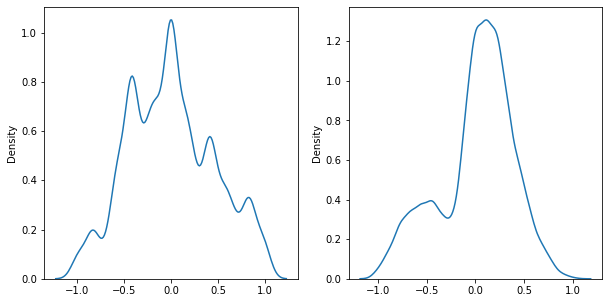

In [47]:
# plot x and y
x_train, y_train = [], []
for fgs in train_fgs:   
    x_train += [fg[-5] for fg in fgs]
    y_train += [fg[-4] for fg in fgs]
row_plot([x_train, y_train], savename='output/xy_train.png')

In [48]:
generated_fgs = [img[-1] for img in generated_images]
generated_fgs = [rescale_fgs(fgs) for fgs in generated_fgs]
print('Statistics of x and y of generated images:')
inspect_xy(generated_fgs)

Statistics of x and y of generated images:
Relative x and y positions: (678 records)
x: [-0.7835820895522388,0.8059701492537313]; 	scaled: [-315.0, 324.0]
y: [-0.7533333333333333,0.56]; 	scaled: [-452.0, 336.00000000000006]
mean x: 	-0.02720908730682869; 	scaled: -10.938053097345133
mean y: 	0.0008702064896755154; 	scaled: 0.5221238938053092
variance x: 	0.12057020513735939; 	scaled: 19484.627431017827
variance y: 	0.07851278748009502; 	scaled: 28264.60349283421


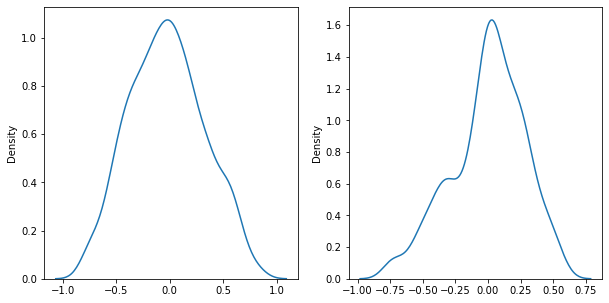

In [49]:
x_gen, y_gen = [], []
for fgs in generated_fgs:   
    x_gen += [fg[-5] for fg in fgs]
    y_gen += [fg[-4] for fg in fgs]
row_plot([x_gen, y_gen], savename='output/xy_gen.png')

2. Compare scale distribution from training data and generated images.

Statistics of scales from training images:
Records of scale:	14910
Range of scale:  	[0.78,1.03];
Mean of scale:   	0.9041240778001342
Variance of scale:	0.005635057709997971


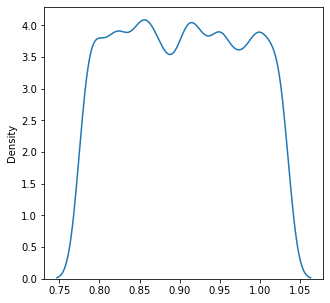

In [50]:
scales = []
for img_info in img_manifest:
    scales += [fg[-3] for fg in img_info['fg']]
print('Statistics of scales from training images:')
show_statistics(scales, 'scale')
row_plot([scales])

Statistics of scales from generated images:
Records of scale:	678
Range of scale:  	[0.8069343566894531,1.0956575187085513];
Mean of scale:   	0.9015230695036157
Variance of scale:	0.0014763648568320437


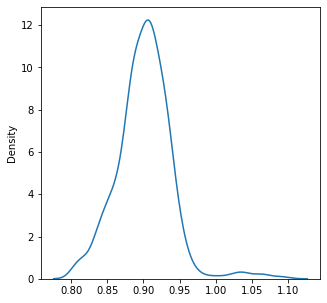

In [51]:
generated_scales = []
for fgs in generated_fgs:
    generated_scales += [fg[-3] for fg in fgs]
print('Statistics of scales from generated images:')
show_statistics(generated_scales, 'scale')
row_plot([generated_scales])

## Visualize Generated Images

#### 1. Define image transformation functions

In [52]:
import numpy as np
import cv2

def tile_image(mat, rows, cols):
    '''
    Tile mat vertically rows times and horizontally cols times
    '''
    tiled_image = np.tile(mat, (rows, cols, 1))
    return tiled_image

def vanilla_rotate(mat, angle):
    '''
    Rotate mat clockwise angle degrees. This operation keeps sizes and scales, which means 
    there will be information loss, i.e. corners of original image.
    
    mat: numpy.ndarray,(h, w, c)
        Matrix to rotate.
    angle: int
        Natural number. It will be moded into [0, 360) 
    '''
    rows,cols = mat.shape[:2]
    # cols-1 and rows-1 are the coordinate limits.
    M = cv2.getRotationMatrix2D(((cols-1)/2.0,(rows-1)/2.0),angle,1)
    rotated = cv2.warpAffine(mat, M, (cols,rows))
    return rotated

def scale_image(mat, scale):
    scaled_mat = cv2.resize(mat,None,fx=scale, fy=scale, interpolation = cv2.INTER_CUBIC)
    return scaled_mat

def transform_image(mat, scale, angle):
    '''
    scale and rotate image in one step
    '''
    scaled_mat = scale_image(mat, scale)
    rotated_mat = vanilla_rotate(scaled_mat, angle)
    return rotated_mat

def overlay_transparent(background, overlay, x, y):
    '''
    Overlay top left coner of 'overlay' onto background at (x, y).
    x, y are expected to be integers.
    '''

    background_width = background.shape[1]
    background_height = background.shape[0]
    h, w = overlay.shape[0], overlay.shape[1]

    # when overlay is totally to the right or bottom of background
    if x >= background_width or y >= background_height:
        return background      
    # when overlay is totally to the left or top of background
    if x + w <= 0 or y + h <= 0:
        return background

    if x + w > background_width:
        w = background_width - x
        overlay = overlay[:, :w]   # truncate overlay's width right

    if y + h > background_height:
        h = background_height - y
        overlay = overlay[:h]      # truncate overlay's height bottom

    if x < 0:
        w = x + w
        overlay = overlay[:, -w:] # truncate overlay's width left
    
    if y < 0:
        h = y + h
        overlay = overlay[-h:]    # truncate overlay's height top

    if overlay.shape[2] < 4:
        overlay = np.concatenate(
            [
                overlay,
                np.ones((overlay.shape[0], overlay.shape[1], 1), dtype = overlay.dtype) * 255
            ],
            axis = 2,
        )

    overlay_image = overlay[..., :4]
    mask = overlay[..., 3:] / 255.0

    y = max(y, 0)
    x = max(x, 0)
    background[y:y+h, x:x+w] = (1.0 - mask) * background[y:y+h, x:x+w] + mask * overlay_image

    return background

#### 2. Define helper functions for plotting image:

`grid_plot` plots generated images in grid.

In [53]:
from matplotlib.pyplot import figure
import math

def grid_plot(images, n_col, dpi=80, savename=None, savedpi=200, transparent=True):
    n_gen = len(images)
    n_row = math.ceil(n_gen / n_col)
    figure(figsize=(14, 4 * n_row), dpi=dpi)
    for i, image in enumerate(images):
        plt.subplot(n_row, n_col, i+1, autoscale_on=True)
        plt.axis('off')
        plt.imshow(image)
    if savename is not None:
        plt.savefig(savename, dpi=savedpi, transparent=transparent)
    plt.show()

#### 3. Define helper functions for combining arts and shadings into images.

In [54]:
def create_blank(width, height, rgb_color=(255, 255, 255), opacity=255):
    """Create new image(numpy array) filled with certain color in RGB"""
    # Create black blank image
    image = np.zeros((width, height, 4), np.uint8)

    # Since OpenCV uses BGR, convert the color first
    color = tuple((*reversed(rgb_color), opacity))
    # Fill image with color
    image[:] = color

    return image

In [55]:
# @unused
def rel2abs(fgs):
    '''
    Convert foreground images from scaled(relative position, scaled rotation) ones back to drawable format.
    '''
    absolute_fgs = []
    for i, fg in enumerate(fgs):
        if i == 0:
            x_last, y_last = 0, 0
        number, rank, rel_x, rel_y, scale, scaled_rotate, opaque = fg
        # constants come from inspection of training data (defined in inspect data section)
        x, y = int(x_last + rel_x * SCALE_FACTOR_X), int(y_last + rel_y * SCALE_FACTOR_Y)
        x_last, y_last = x, y
        rotate = int(scaled_rotate * 360)
        absolute_fgs.append((number, rank, x, y, scale, rotate, opaque))
    return absolute_fgs

`combine_fgs` combines all sets of foregrounds, and overlay it on to a background:

test snipset:
```python
fg_combined = combine_fgs(fgs)
print(fg_combined.shape)
plt.imshow(fg_combined)
```

In [56]:
def combine_fgs(fgs):
    '''
    Combine all foregrounds into a transparent foreground sticker
    
    Parameters:
    fgs (list): a list of (number, rank, x, y, scale, rotate, opaque) tuples.
    '''
    abs_fgs = np.array(fgs)
    min_x, max_x = np.min(abs_fgs[:, 2]), np.max(abs_fgs[:, 2])
    min_y, max_y = np.min(abs_fgs[:, 3]), np.max(abs_fgs[:, 3])
    # 120 is a buffer for the width and height of the right-/bottom-most image
    span_x = int(max_x - min_x) + 120 
    span_y = int(max_y - min_y) + 120
    # avoid span_x and span_y to be too large
    span_x = min(span_x, 2000)
    span_x = min(span_y, 2000)
    # move the start of foregrounds to topleft
    abs_fgs[:, 2] -= min_x
    abs_fgs[:, 3] -= min_y
    bg = create_blank(span_x, span_y, opacity=0)
    for fg in abs_fgs:
        number, rank, x, y, scale, rotate, opaque = fg
        # convert np.float to int
        number, x, y, rotate = int(number), int(x), int(y), int(rotate)
        fg = cv2.imread(get_fg_path(number), -1)
        cursor = (y, x)
        fg = transform_image(fg, scale, rotate)
        bg = overlay_transparent(bg, fg, cursor[0], cursor[1])
    changed_color = cv2.cvtColor(bg, cv2.COLOR_BGRA2RGBA)
    return changed_color

`tile_overlay` tiles foreground images and fully fills the given background.

```python
# test snipset:
background = create_blank(2000, 2000, opacity=0)
overlay = fg_combined
combined = tile_overlay(background, overlay, 800, 500)
plt.imshow(combined)
plt.show()
```

In [57]:
import math

def tile_overlay(background, overlay, x=0, y=0):
    '''
    Tile overlay multiple times to fully cover background.
    
    Parameters:
    background (mat):
    overlay (mat):
    x (int): inital transition of overlay's top-left corner on x axis
    y (int): inital transition of overlay's top-left corner on y axis
    '''
    background_width = background.shape[1]
    background_height = background.shape[0]
    h, w = overlay.shape[0], overlay.shape[1]
    
    # re-place x (to make sure top is fully filled)
    x = x - math.ceil(x / h) * h
    # re-place y (to make sure left is fully filled)
    y = y - math.ceil(y / w) *  w
    
    # needed foreground on x axis
    num_rows = math.ceil((background_height - x) / h)
    # needed foreground on y axis
    num_cols = math.ceil((background_width - y) / w)
    for i in range(num_rows):
        for j in range(num_cols):
            overlay_x = x + i * h
            overlay_y = y + j * w
            # exchange x and y because overlay_transparent use a different coordinate
            background = overlay_transparent(background, overlay, overlay_y, overlay_x)
    return background

In [58]:
def draw_tiled_image(bg, bg_color, fgs):
    background_height = 1500
    background_width = 1500

    if isinstance(bg_color, str):
        blank = create_blank(background_width, background_height, hex2rgb(bg_color))
    else:
        blank = create_blank(background_width, background_height, bg_color)

    bg = cv2.imread(get_bg_path(bg), -1) # -1 flag reads alpha channel
    bg = scale_image(bg, 2)
    tiled = tile_image(bg, 14, 14)
    bg = overlay_transparent(blank, tiled[:background_height, :background_width], 0, 0)
    combined_fgs = combine_fgs(fgs)
    bg = tile_overlay(bg, combined_fgs)
    changed_color = cv2.cvtColor(bg, cv2.COLOR_BGRA2RGBA)
    return changed_color

#### 4. Plot tiled generated images.

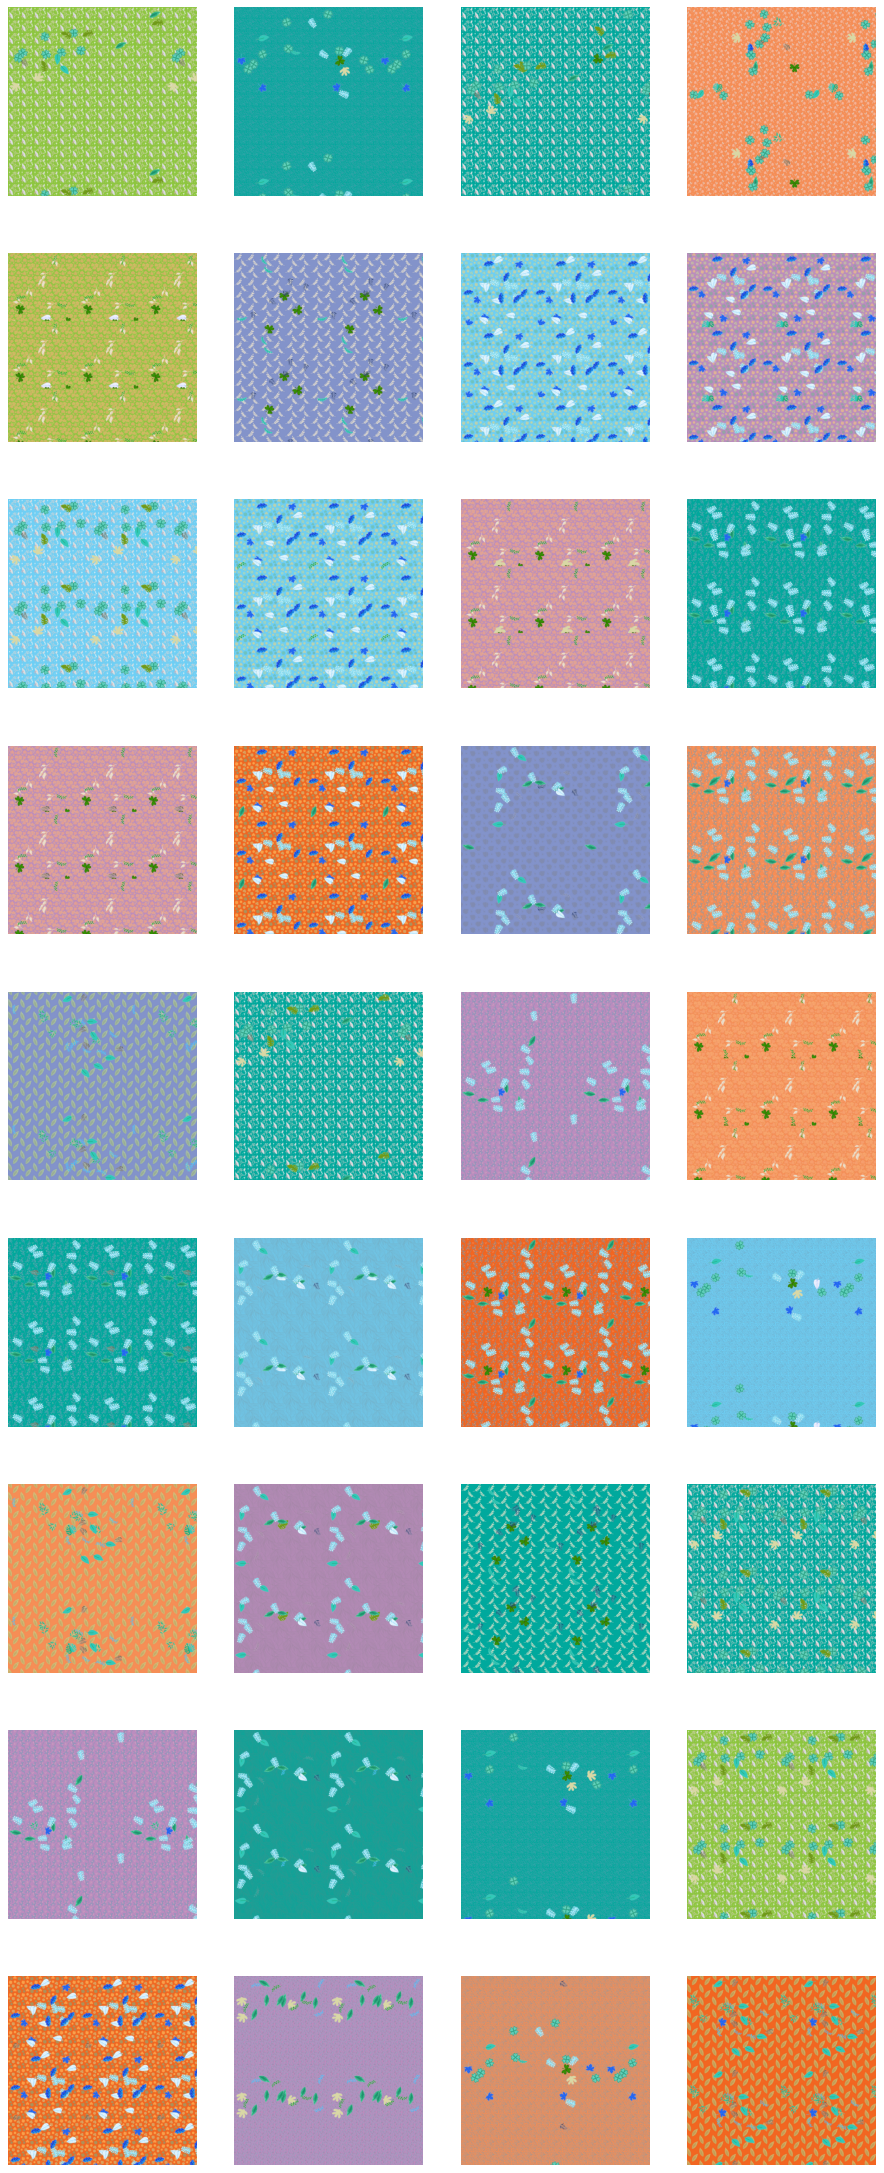

In [59]:
tiled_plots = [draw_tiled_image(bg, bg_color, fgs) for bg, bg_color, fgs in generated_images]
grid_plot(tiled_plots, 4, savename='output/generated.png')

## Draw some figures for slides

### Image generation step by step

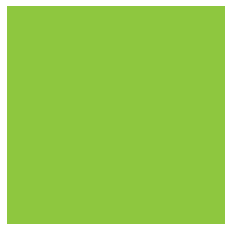

In [60]:
bg, bg_color, fgs = generated_images[4]
background_height = 1500
background_width = 1500
if isinstance(bg_color, str):
    blank = create_blank(background_width, background_height, hex2rgb(bg_color))
else:
    blank = create_blank(background_width, background_height, bg_color)
blank_changed_color = cv2.cvtColor(blank, cv2.COLOR_BGRA2RGBA)
plt.imshow(blank_changed_color)
plt.axis('off')
plt.savefig('output/blank.png', transparent=True)

In [61]:
bg = cv2.imread(get_bg_path(bg), -1) # -1 flag reads alpha channel
bg = scale_image(bg, 2)
tiled = tile_image(bg, 14, 14)
bg = overlay_transparent(blank, tiled[:background_height, :background_width], 0, 0)

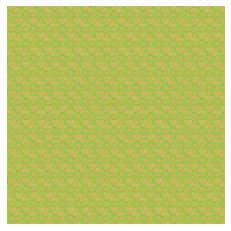

In [62]:
bg_changed_color = cv2.cvtColor(bg, cv2.COLOR_BGRA2RGBA)
plt.imshow(bg_changed_color)
plt.axis('off')
plt.savefig('output/tiled_bg.png', transparent=False)

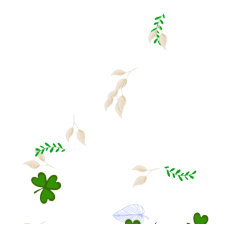

In [63]:
combined_fgs = combine_fgs(fgs)
combined_fgs_changed_color = cv2.cvtColor(combined_fgs, cv2.COLOR_BGRA2RGBA)
plt.imshow(combined_fgs_changed_color)
plt.axis('off')
plt.savefig('output/combined_fgs_transparent.png', transparent=True)

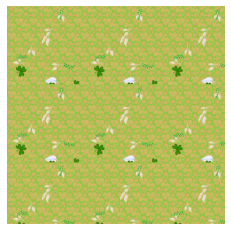

In [64]:
overlayed_img = tile_overlay(bg, combined_fgs)
overlayed_img_changed_color = cv2.cvtColor(overlayed_img, cv2.COLOR_BGRA2RGBA)
plt.imshow(overlayed_img_changed_color)
plt.axis('off')
plt.savefig('output/overlayed_bg.png', transparent=False)